# Фрактальное сжатие

## Немного теории
Алгоритм описан в главе про [сжатие изображений](https://compression.ru/book/part2/part2__3.htm#_Toc448152512).

### Определения
**Ранговый блок**: если исходное изображение разбивается на непересекающиеся блоки одинакового размера, замощающие всё изображение, то каждый такой блок называется *ранговым*; имеют меньший размер, чем доменные блоки.

**Доменный блок**: если исходное изображение разбивается блоки одинакового размера, которые могут и пересекаться, то каждый такой блок называется *доменным*; имеют больший размер, чем ранговые блоки.

**Идея алгоритма**:

При сжатии:
1. для каждого рангового блока найти наиболее похожий на него доменный блок (с учётом поворотов и симметрии)
2. выполнить преобразование яркости
3. в качестве сжатого изображения выступают коэффициенты преобразования ранговых блоков, эффективно записанные в файл (строку)

При декомпрессии:
1. Прочитать файл (строку), извлечь коэффициенты преобразований
2. Применить преобразования к исходному изображению (обычно просто серое) пока результат не стабилизируется

In [69]:
# Standard Python Library

import itertools
import time

from collections import deque
from typing import NamedTuple

# Additional Modules

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import display
from IPython.display import Image

import numpy as np

import pandas as pd

from skimage import io
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

# Global config

plt.rc('figure', figsize=(18, 6))

Первым делом нужно загрузить картинку

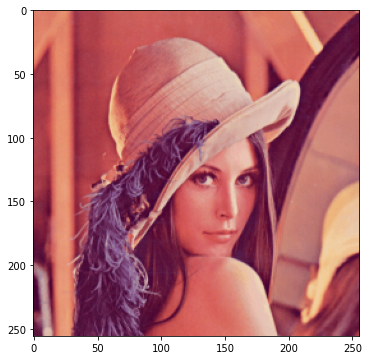

In [2]:
lenna_rgb_256x256 = resize(io.imread('test_files/lenna.bmp'), (256, 256))
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype(np.uint8)
lenna_rgb_256x256 = np.rint(lenna_rgb_256x256 * 255).astype(np.uint8)

plt.imshow(lenna_rgb_256x256)

## Общие функции
Функции и классы, используемые при написании алгоритма.

In [3]:
class BlockTransform(NamedTuple):
    x: int
    y: int
    intensity_offset: int
    flip: bool
    rotates: int
    bad: int

In [4]:
class FractalCompressionParams(NamedTuple):
    height: int
    width: int
    is_colored: bool
    block_size: int
    uv_block_size: int
    spatial_scale: float
    intensity_scale: float
    stride: int

In [5]:
def derive_num_bits(length, stride):
    return np.ceil(np.log2(length / stride)).astype(int)

In [6]:
def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))

### Функция для нахождения наилучшего преобразования рангового блока

#### Как искать повороты и отражения?

Простейший способ -- перепробовать все комбинации и найти лучшую.

В качестве улучшения можно разбить ранговый и доменные блоки на четыре части, отсортировать их по яркости и по взаимному положению блоков определить нужную трансформацию.

Такое решение повышает скорость примерно в 6 раз при потере в качестве около 0.4 PSNR

In [7]:
class FR(NamedTuple):
    flip: bool
    rotates: int

def find_flip_rotate(domain_block, rank_block, block_size):
    """Find flip and rotate through split blocks to 4 quadrants and compare they.

    Parameters
    ----------
    domain_block, rank_block : np.array, np.array
        Compared blocks

    block_size : int
        Size of rank block.

    Returns
    -------
    fr : FR
        Transformations parameters: flip and rotates

    """

    xs = range(0, block_size, block_size // 2)
    ys = range(0, block_size, block_size // 2)

    quadrants = tuple(np.s_[x : x + block_size // 2, y : y + block_size // 2] for x, y in itertools.product(xs, ys))

    presets = [[None, FR(flip=False, rotates=0), None, FR(flip=True,  rotates=1)],
               [FR(flip=True,  rotates=0), None, FR(flip=False, rotates=1), None],
               [None, FR(flip=True,  rotates=3), None, FR(flip=False, rotates=2)],
               [FR(flip=False, rotates=3), None, FR(flip=True,  rotates=2), None]]

    db_sums = {num + 1: domain_block[quadrant].sum() for num, quadrant in enumerate(quadrants)}

    dbs = sorted(db_sums, key=db_sums.get)

    rb_sums = {num + 1: rank_block[quadrant].sum() for num, quadrant in enumerate(quadrants)}

    rbs = sorted(rb_sums, key=rb_sums.get)

    match_1 = dbs[rbs.index(1)] - 1
    match_2 = dbs[rbs.index(2)] - 1

    return presets[match_1][match_2]

#### Как искать intensity_scale и intensity_offset?

Решим задачу
$$
min_{a, b} E - ?\\
$$

где 

$$
E(a, b) = \sum_{i=1}^n \sum_{j=1}^n (R_{ij} - (a D_{ij} + b))^2\\
$$

а $a$ - intensity scale, $b$ - intensity offset, $R_{ij}$, $D_{ij}$ - ранговые и доменные блоки соответственно.

Найдем частные производные по $a$

$$
\frac{\partial E}{\partial a} = \sum_{i=1}^n \sum_{j=1}^n 2 (R_{ij} - (a D_{ij} + b)) (-D_{ij}) = 2 \sum_{i=1}^n \sum_{j=1}^n (a D_{ij}^2 + b D_{ij} - R_{ij} D_{ij})\\
$$

и по $b$

$$
\frac{\partial E}{\partial b} = \sum_{i=1}^n \sum_{j=1}^n 2 (R_{ij} - (a D_{ij} + b)) (-1) = 2 \sum_{i=1}^n \sum_{j=1}^n (a D_{ij} + b - R_{ij})\\
$$

На практике вычисляемый $a$ не дает больших преимуществ по качеству (+0.3 PSNR), но немного проигрывает по времени и значительно по размеру сжатого изображения. Будем оптимизировать только $b$.

Ищем экстремум, приравнивая функцию к нулю.

$$
\sum_{i=1}^n \sum_{j=1}^n (a D_{ij} + b - R_{ij}) = 0\\
$$

Раскрываем скобки и переносим слагаемые, содержащие $b$, в одну сторону.

$$
n^2 b = \sum_{i=1}^n \sum_{j=1}^n R_{ij} - a \sum_{i=1}^n \sum_{j=1}^n D_{ij}\\
$$

Мы получили формулу для коэффициента $b$

$$
b = mean(R - a D)\\
$$

Перебором приходим к оптимальному $a=0.75$

In [8]:
def find_block_transform(image, resized_image, x, y, block_size, stride, intensity_scale=0.75, loss_limit=256):
    """Find best transformation for given rank block.

    Parameters
    ----------
    image : np.array
        Source B/W image.

    resized_image : np.array
        Resized source image.

    x, y : int, int
        Coordinates of the rank block.
    
    block_size : int
        Size of rank block.

    stride : int
        Vertical and horizontal stride for domain block search.

    intensity_scale : float, optional (default=0.75)
        Reduce coefficient for image intensity.

    loss_limit : int, optional (default=512)
        Error limit for founded block in terms of MSE

    Returns
    -------
    best_transform : BlockTransform
        Best transformation.

    """

    best_transform = BlockTransform(x=0, y=0, intensity_offset=0, flip=False, rotates=0, bad=True)
    best_transform_loss = float('inf')

    rank_block = image[x : x + block_size, y : y + block_size]

    xs = range(0, resized_image.shape[0] - block_size + 1, stride)
    ys = range(0, resized_image.shape[1] - block_size + 1, stride)

    for domain_x, domain_y in itertools.product(xs, ys):
        domain_block = resized_image[domain_x : domain_x + block_size, domain_y : domain_y + block_size]

        fr = find_flip_rotate(domain_block, rank_block, block_size)

        if fr is None:
            continue

        if fr.flip:
            domain_block = np.flip(domain_block, axis=1)

        domain_block = np.rot90(domain_block, k=fr.rotates)

        intensity_offset = np.mean(rank_block - intensity_scale * domain_block).astype(np.int8)  # See explanations above

        loss = mse(intensity_scale * domain_block + intensity_offset, rank_block)
        if loss < best_transform_loss:
            best_transform = BlockTransform(x=domain_x, y=domain_y, intensity_offset=intensity_offset, flip=fr.flip, rotates=fr.rotates, bad=loss >= loss_limit)
            best_transform_loss = loss

            if not best_transform.bad:
                break

    return best_transform

#### Лучшее -- враг хорошего

Идея остановки поиска при достижении заданной похожести блоков ускоряет алгоритм на порядок. Но возникает проблема: большая часть блоков берется из левого верхнего угла (смотри визуализацию ниже). Для устранения проблемы можно попробовать модифицировать перебор (например перебирать по спирали от стартового блока к краям). Но кажется, что это не проблема, а особенность алгоритма. По крайней мере, при полном переборе алгоритм ведет себя похоже.

#### Посмотрим, где мы находим блоки

In [9]:
def find_simple_transforms(image, block_size, stride):
    """Find simple (not use quadtree) transformations for given image.

    Use this function for visualization.

    Parameters
    ----------
    image : np.array
        Source B/W image.

    block_size : int
        Size of rank block.

    stride : int
        Vertical and horizontal stride for domain block search.

    Returns
    -------
    transforms : array of tuples (x, y, BlockTransform)
        x, y are coordinates of rank block for which we find transform

    """

    image = image.astype(np.double)
    resized_image = resize(image, (image.shape[0] // 2, image.shape[1] // 2))

    # Splitting source image into rank blocks
    xs = range(0, image.shape[0], block_size)
    ys = range(0, image.shape[1], block_size)

    transforms = []
    for x, y in tqdm(itertools.product(xs, ys), total=len(xs) * len(ys)):
        transform = find_block_transform(image, resized_image, x, y, block_size, stride)
        transforms.append((x, y, transform))

    return transforms

simple_transforms = find_simple_transforms(lenna_gray_256x256, block_size=16, stride=4)

100%|██████████| 256/256 [00:10<00:00, 25.50it/s]


In [ ]:
def save_transforms(image, transforms, block_size):
    """Save each transform on image as mp4 video.

    Rank block is red, domain block is green. If transform is bad then blocks have face color.

    Parameters
    ----------
    image : np.array
        Source B/W image.

    transforms : array of tuples (x, y, BlockTransform)
        x, y are coordinates of rank block for which we find transform

    block_size : int
        Size of rank block.

    """

    def animate(index):
        x, y, transform = simple_transforms[index]
        plt.clf()
        plt.imshow(image, cmap='gray')
        plt.gca().add_patch(Rectangle((x, y), block_size, block_size, linewidth=1, edgecolor='r', facecolor='r' if transform.bad else 'none'))
        plt.gca().add_patch(Rectangle((transform.x, transform.y), block_size * 2, block_size * 2, linewidth=2, edgecolor='g', facecolor='g' if transform.bad else 'none'))

    ani = matplotlib.animation.FuncAnimation(plt.figure(), animate, frames=len(simple_transforms))

    ani.save('images/simple_transforms.gif', writer='imagemagick')

save_transforms(lenna_gray_256x256, simple_transforms, block_size=16)

![Simple transforms](images/simple_transforms.gif)

#### Где мы нашли недостаточно хорошие блоки?

Доля плохих блоков: 0.4140625


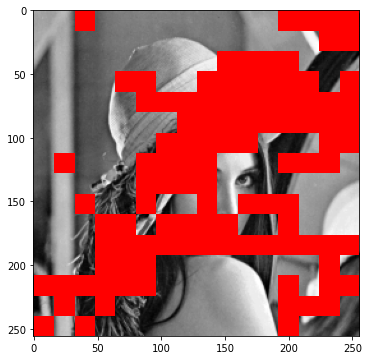

In [12]:
def show_bad_blocks(image, transforms, block_size):
    """Show bad block for given image. Red blocks are bad.

    Parameters
    ----------
    image : np.array
        Source B/W image.

    transforms : array of tuples (x, y, BlockTransform)
        x, y are coordinates of rank block for which we find transform

    block_size : int
        Size of rank block.

    """

    # Splitting source image into rank blocks
    xs = range(0, image.shape[0], block_size)
    ys = range(0, image.shape[1], block_size)

    plt.imshow(image, cmap='gray')
    for x, y, t, in transforms:
        plt.gca().add_patch(Rectangle((x, y), block_size, block_size, linewidth=1, edgecolor='none', facecolor='r' if t.bad else 'none'))

    print('Доля плохих блоков:', sum(t.bad for _,_,t in transforms) / (len(xs) * len(ys)))

show_bad_blocks(lenna_gray_256x256, simple_transforms, block_size=16)

### Применение IFS к изображению

In [13]:
def get_transforms_for_current_block(transforms):
    """Recursively find transforms for one rank block.

    If transform is bad then there are 4 more transforms for this rank block.

    Parameters
    ----------
    transforms : list of BlockTransform's
        Given IFS, Iterated Function System

    Returns
    -------
    block_transforms : deque of BlockTransform's
        Deque of all transforms for one rank_block

    """

    t = transforms.popleft()
    block_transforms = [t]

    if t.bad:
        for _ in range(4): # Quadtree
            block_transforms.extend(get_transforms_for_current_block(transforms))

    return deque(block_transforms)

def apply_transforms(transformed_image, resized_image, x, y, block_size, block_transforms, intensity_scale):
    """Recursively apply transforms for current rank block.

    If transform is bad then there are 4 more transforms for this rank block.

    Parameters
    ----------
    transformed_image : np.array
        Image to apply transforms

    resized_image : np.array
        Resized source image.

    x, y : int, int
        Coordinates of rank_block

    block_size : int
        Size of rank block.

    block_transforms : list of BlockTransform's
        List of all transforms for current rank_block

    intensity_scale : float
        Reduce coefficient for image intensity.

    """

    transform = block_transforms.popleft()
    if transform.bad:
        xs = range(x, x + block_size, block_size // 2)
        ys = range(y, y + block_size, block_size // 2)

        for x_, y_ in itertools.product(xs, ys):
            apply_transforms(transformed_image, resized_image, x_, y_, block_size // 2, block_transforms, intensity_scale)
    else:
        domain_block = resized_image[transform.x : transform.x + block_size,
                                     transform.y : transform.y + block_size]

        if transform.flip:
            domain_block = np.flip(domain_block, axis=1)

        domain_block = np.rot90(domain_block, k=transform.rotates)

        transformed_image[x : x + block_size,
                          y : y + block_size] = intensity_scale * domain_block + transform.intensity_offset

def perform_transform(image, resized_image, transforms, block_size, intensity_scale=0.75):
    """Perform IFS on given image.
    
    Parameters
    ----------
    image : np.array
        Source image.

    resized_image : np.array
        Resized source image.

    transforms : list of BlockTransform's
        Given IFS, Iterated Function System
    
    block_size : int
        Size of rank block.
            
    intensity_scale : float, optional (default=0.75)
        Reduce coefficient for image intensity.

    Returns
    -------
    transformed_image : np.array
        Transformed image.

    """

    transformed_image = np.zeros_like(image)

    xs = range(0, image.shape[0], block_size)
    ys = range(0, image.shape[1], block_size)

    transforms = deque(transforms)

    for x, y in itertools.product(xs, ys):
        block_transforms = get_transforms_for_current_block(transforms)
        apply_transforms(transformed_image, resized_image, x, y, block_size, block_transforms, intensity_scale)

    return transformed_image

#### Проверим, что связка find + perform работает

In [14]:
def test_transform():
    tests = (((np.array([[1, 2],
                                    [3, 4]]),
                         np.array([[4, 6], 
                                   [8, 10]]),
                         0, 0, 2, 1), 
                        0.5),
                       ((np.array([[1, 2], 
                                   [3, 4]]),
                         np.array([[4, 6, 7, 6], 
                                   [6, 7, 5, 4]]),
                         0, 0, 2, 1), 
                        0.5),
                       ((np.array([[1, 2], 
                                   [3, 4]]),
                         np.array([[4, 2, 3, 6], 
                                   [6, 4, 5, 5]]),
                         0, 0, 2, 2),
                        0.25))

    for test, answer in tests:
        transform = find_block_transform(*test)
        img, resized_img, x, y, block_size, stride = test
        transformed = perform_transform(np.zeros_like(img), resized_img, [transform], block_size)
        loss = mse(img, transformed)
        if loss > answer + 1e-5:
            return False
    return True

test_transform()

True

### Класс, реализующий интерфейс битового массива
Он понадобится для преобразования найденной IFS в строку, чтобы записать сжатый файл на диск.

In [15]:
# GRADED CELL: BitBuffer

class BitBuffer:
    """Class that provides storing and and reading integer numbers 
    in continuous bytearray.

    Parameters
    ----------
    buffer : bytearray, optional (default=None)
        Input bytearray, for initialization.

    Attributes
    ----------
    _pushed_bits : int
        Count of pushed into last byte bits

    _left_bits : int
        Count of bits that can be popped from first byte

    _buf_cap : int
        Max bits in byte

    _buffer : bytearray
        Bytearray that can contain any information.

    Examples
    --------
    >>> buffer = BitBuffer()
    >>> buffer.push(1, 1)
    >>> buffer.pop(1)
    1
    >>> buffer.push(125, 18)
    >>> buffer.pop(18)
    125
    >>> buffer.push(5, 3)
    >>> buffer.pop(3)
    5
    
    """

    def __init__(self, buffer=None):
        self._pushed_bits = 0
        self._left_bits = 8
        self._buf_cap = 8
        self._buffer = buffer or bytearray(1)

    def to_bytearray(self):
        """Convert to bytearray.
    
        Returns
        -------
        buffer: bytearray
            Bytearray that contains all data.

        """

        return self._buffer

    def _push_bit(self, bit):
        """Push given bit to buffer.

        Parameters
        ----------
        bit: int
            Input bit.
        """

        if self._pushed_bits == self._buf_cap:
            self._buffer.append(0)
            self._pushed_bits = 0

        self._buffer[-1] |= bit << (self._buf_cap - 1 - self._pushed_bits)
        self._pushed_bits += 1

    def _pop_bit(self):
        """Pop one bit from buffer.

        Returns
        -------
        bit: int
            Popped bit.

        """

        if not self._left_bits:
            self._buffer.pop(0)
            self._left_bits = self._buf_cap

        bit = (self._buffer[0] & 1 << (self._left_bits - 1)) >> (self._left_bits - 1)
        self._left_bits -= 1

        return bit

    def push(self, x, n_bits):
        """Push given integer to buffer.
    
        Parameters
        ----------
        x: int
            Input number.

        n_bits: int
            Number of bits for store input number,
            should be greater than log2(x).

        """

        assert x < 2 ** n_bits, f"{x} >= 2^{n_bits}"

        bits_left = n_bits

        while bits_left:
            bit = (x & (1 << (bits_left - 1))) >> (bits_left - 1)
            self._push_bit(bit)
            bits_left -= 1

    def pop(self, n_bits):
        """Pop n_bits from buffer and transform it to a number.
    
        Parameters
        ----------
        n_bits: int
            Number of bits for pop from buffer.

        Returns
        -------
        x: int
            Extracted number.

        """

        bits_left = n_bits
        x = 0

        while bits_left:
            x |= self._pop_bit() << (bits_left - 1)
            bits_left -= 1

        return x

#### Проверим, что битовый массив правильно работает

In [16]:
def test_bit_buffer():
    bb = BitBuffer()
    bb.push(15, 6)
    bb.push(0, 7)
    bb.push(1, 1)
    bb.push(100, 400)
    answer = [15, 0, 1, 100]

    res2 = [bb.pop(6), bb.pop(7), bb.pop(1), bb.pop(400)]
    if res2 == answer:
        return True

    return False

test_bit_buffer()

True

В дальнейшем можно попробовать сжать битовый массив алгоритмом сжатия без потерь.

### Класс, реализующий интерфейс архиватора изображений

In [17]:
# GRADED CELL: FractalCompressor

class FractalCompressor:
    """Class that performs fractal compression/decompression of images.

    Attributes
    ----------
    _num_bits_ver : int
        Number of bits for store VERTICAL OFFSET for each transformation.

    _num_bits_hor : int
        Number of bits for store HORIZONTAL OFFSET for each transformation.

    _num_bits_pix : int
        Number of bits for store INTENSITY OFFSET for each transformation.

    _num_bits_tfm : int
        Number of bits for store TRANSFORMATION INDEX for each transformation.

    _num_bits_flip : int
        Number of bits for store FLIP for each transformation.

    _num_bits_rotates : int
        Number of bits for store ROTATES for each transformation.

    _num_bits_bad : int
        Number of bits for store flag of split into 4 block for each transformation.

    """

    def __init__(self):
        self._num_bits_ver = 8
        self._num_bits_hor = 8
        self._num_bits_pix = 8
        self._num_bits_tfm = 3
        self._num_bits_flip = 1
        self._num_bits_rotates = 2
        self._num_bits_bad = 1

    def _add_header(self, buffer, params):
        """Store header in buffer.

        Parameters
        ----------
        buffer: BitBuffer

        params: FractalCompressionParams
            Parameters that should be stored in buffer.

        Note
        ----
        This method must be consistent with `_read_header`.

        """

        buffer.push(params.height, 16)
        buffer.push(params.width, 16)
        buffer.push(params.is_colored, 1)
        buffer.push(params.block_size, 8)
        buffer.push(params.uv_block_size, 8)
        buffer.push(np.rint(params.spatial_scale * 255).astype(np.uint8), 8)
        buffer.push(np.rint(params.intensity_scale * 255).astype(np.uint8), 8)
        buffer.push(params.stride, 8)

    def _read_header(self, buffer):
        """Read header from buffer.

        Parameters
        ----------
        buffer: BitBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted parameters.

        Note
        ----
        This method must be consistent with `_add_header`.

        """

        params = FractalCompressionParams(
            height = buffer.pop(16),
            width = buffer.pop(16),
            is_colored = bool(buffer.pop(1)),
            block_size = buffer.pop(8),
            uv_block_size = buffer.pop(8),
            spatial_scale = buffer.pop(8) / 255,
            intensity_scale = buffer.pop(8) / 255,
            stride = buffer.pop(8)
        )

        return params

    def _add_to_buffer(self, buffer, transform, stride):
        """Store block transformation in buffer.

        Parameters
        ----------
        buffer: BitBuffer

        transform: BlockTransform

        stride: int
            Vertical and horizontal stride for domain block search.

        Note
        ----
        This method must be consistent with `_read_transform`.

        """

        buffer.push(transform.bad, self._num_bits_bad)
        if not transform.bad:
            buffer.push(transform.x // stride, derive_num_bits(2 ** self._num_bits_ver, stride))
            buffer.push(transform.y // stride, derive_num_bits(2 ** self._num_bits_hor, stride))
            buffer.push(transform.intensity_offset + 128, self._num_bits_pix)
            buffer.push(transform.flip, self._num_bits_flip)
            buffer.push(transform.rotates, self._num_bits_rotates)

    def _read_transform(self, buffer, stride):
        """Read block transformation from buffer.

        Parameters
        ----------
        buffer: BitBuffer

        stride: int
            Vertical and horizontal stride for domain block search.

        Returns
        -------
        transform: BlockTransform
            Extracted block transformation.

        Note
        ----
        This method must be consistent with `_add_to_buffer`.

        """

        bad = bool(buffer.pop(self._num_bits_bad))

        if bad:
            return BlockTransform(x=0, y=0, intensity_offset=0, flip=False, rotates=0, bad=True)

        return BlockTransform(
            x = buffer.pop(derive_num_bits(2 ** self._num_bits_ver, stride)) * stride,
            y = buffer.pop(derive_num_bits(2 ** self._num_bits_hor, stride)) * stride,
            intensity_offset = buffer.pop(self._num_bits_pix) - 128,
            flip = bool(buffer.pop(self._num_bits_flip)),
            rotates = buffer.pop(self._num_bits_rotates),
            bad=bad
        )

    def _ifs2buf(self, params, transformations):
        """Store compression parameters and IFS in buffer.

        Parameters
        ----------
        params: FractalCompressionParams
            Parameters of the compression.

        transformations: list of BlockTransform's
            Given IFS.

        Returns
        -------
        buffer: BitBuffer

        Note
        ----
        This method must be consistent with `_buf2ifs`.

        """

        buffer = BitBuffer()
        self._add_header(buffer, params)
        for t in transformations:
            self._add_to_buffer(buffer, t, params.stride)

        return buffer

    def _read_transform_for_block(self, buffer, block_size, stride):
        """Recursively get all transforms for one rank block.

        If transform is bad then there are 4 more transforms for this rank block.

        Parameters
        ----------
        buffer : BitBuffer

        block_size : int
            Size of rank block.

        stride : int
            Vertical and horizontal stride for domain block search.

        Returns
        -------
        transforms : list of BlockTransform's
            List of all transforms for this rank_block

        """

        transform = self._read_transform(buffer, stride)
        transforms = [transform]
        if transform.bad:
            for _ in range(4):  # Quadtree
                transforms.extend(self._read_transform_for_block(buffer, block_size // 2, stride))
        return transforms

    def _read_transforms(self, buffer, num_transforms, block_size, stride):
        """Read transforms.

        Parameters
        ----------
        buffer : BitBuffer

        num_transforms : int
            Number of transforms to read

        block_size : int
            Size of rank block.

        stride : int
            Vertical and horizontal stride for domain block search.

        Returns
        -------
        transforms : list of BlockTransform's
            List of all transforms

        """

        transforms = []
        for _ in range(num_transforms):
            transforms.extend(self._read_transform_for_block(buffer, block_size, stride))

        return transforms

    def _buf2ifs(self, buffer):
        """Store compression parameters and IFS in buffer.

        Parameters
        ----------
        buffer: BitBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted compression parameters.
        transforms, transforms_{u,y,v}: list of BlockTransform's
            Extracted IFS.

        Note
        ----
        This method must be consistent with `_ifs2buf`.

        """

        params = self._read_header(buffer)

        num_transforms = int(params.height * params.width / params.block_size ** 2)

        if params.is_colored:
            num_transforms_uv = int(params.height * params.width / params.uv_block_size ** 2)

            transforms_y = self._read_transforms(buffer, num_transforms, params.block_size, params.stride)
            transforms_u = self._read_transforms(buffer, num_transforms_uv, params.uv_block_size, params.stride)
            transforms_v = self._read_transforms(buffer, num_transforms_uv, params.uv_block_size, params.stride)
        else:
            transforms_y = self._read_transforms(buffer, num_transforms, params.block_size, params.stride)
            transforms_u = transforms_v = None

        return params, transforms_y, transforms_u, transforms_v

    def _compress_block(self, image, resized_image, x, y, block_size, stride, block_size_limit, loss_limit):
        """Recursively find transforms for rank block.

        If transform is bad then find 4 more transforms for this rank block.
        block_size_limit limits minimal size of rank block.

        Parameters
        ----------
        image : np.array
            Source image.

        resized_image : np.array
            Resized source image.

        x, y : int, int
            Coordinates of the rank block.

        block_size : int
            Size of rank block.

        stride : int
            Vertical and horizontal stride for domain block search.

        block_size_limit : int
            Min block_size to use

        loss_limit : int
            Loss limit for founded block in terms of MSE

        Returns
        -------
        transforms : list of BlockTransform's
            Transformations for rank block.

        """

        transform = find_block_transform(image, resized_image, x, y, block_size, stride, loss_limit=loss_limit)

        transforms = [transform]

        if transform.bad:
            if block_size > block_size_limit:
                xs = range(x, x + block_size, block_size // 2)
                ys = range(y, y + block_size, block_size // 2)

                for x_, y_ in itertools.product(xs, ys):
                    transforms.extend(
                        self._compress_block(image, resized_image, x_, y_, block_size // 2, stride, block_size_limit, loss_limit)
                    )
            else:
                transforms[0] = transforms[0]._replace(bad=False)

        return transforms

    def _compress_one_component(self, image, block_size, stride, block_size_limit, loss_limit):
        """Compress one color component of input image

        Parameters
        ----------
        image : np.array
            Source image.

        block_size: int, optional (default=8)
            Size of rank block.

        stride: int, optional (default=1)
            Vertical and horizontal stride for domain block search.

        block_size_limit : int
            Min block_size to use

        loss_limit : int
            Loss limit for founded block in terms of MSE

        Returns
        -------
        transformations : list of BlockTransform's
            Transformations for color component.

        """

        # Instead of reducing each domain block we will reduce the entire image
        resized_image = resize(image, (image.shape[0] // 2, image.shape[1] // 2))

        # Splitting source image into rank blocks
        xs = range(0, image.shape[0], block_size)
        ys = range(0, image.shape[1], block_size)

        transformations = []
        for x, y in tqdm(itertools.product(xs, ys), total=len(xs) * len(ys)):
            transforms = self._compress_block(
                image, resized_image,
                x, y, block_size, stride, block_size_limit, loss_limit
            )
            transformations.extend(transforms)

        return transformations

    def rgb2yuv8(self, image):
        """Convert image from rgb to my own format based on YUV.

        RGB -> YUV -> Scale to UINT

        Parameters
        ----------
        image: np.array
            Source rgb image

        Returns
        -------
        y8, u8, v8: np.array, np.array, np.array
            Color components

        """

        y, u, v = np.split(rgb2yuv(image), [1,2], axis=2)

        y8 = (y + 0.000) * 255
        u8 = (u + 0.436) * 292
        v8 = (v + 0.615) * 207

        return y8, u8, v8

    def yuv82rgb(self, y8, u8, v8):
        """Convert image from my own format based on YUV to RGB.

        Scale from UINT to FLOAT -> YUV -> RGB

        Parameters
        ----------
        y8, u8, v8: np.array, np.array, np.array
            Color components

        Returns
        -------
        image: np.array
            rgb image

        """

        y = y8 / 255 - 0.000
        u = u8 / 292 - 0.436
        v = v8 / 207 - 0.615

        rgb = yuv2rgb(np.dstack((y, u, v)))

        rgb = np.rint(rgb * 255)
        rgb[rgb < 0] = 0
        rgb[rgb > 255] = 255

        return rgb.astype(np.uint8)

    def compress(self, image, block_size=8, stride=4, spatial_scale=0.5, intensity_scale=0.75, block_size_limit=2, uv_block_size=16, loss_limit=256):
        """Compress input image

        Parameters
        ----------
        image : np.array
            Source image.

        block_size: int, optional (default=8)
            Size of rank block.

        stride: int, optional (default=1)
            Vertical and horizontal stride for domain block search.

        spatial_scale : float, optional (default=0.5)
            ({rank block size} / {domain block size}) ratio, must be <1.

        intensity_scale : float, optional (default=0.75)
            Reduce coefficient for image intensity.

        block_size_limit : int, optional (default=8)
            Min block_size to use

        uv_block_size : int, optional (default=16)
            Size of rank block for U and V components of colored image

        loss_limit : int, optional(default=256)
            Error limit for founded block in terms of MSE

        Returns
        -------
        byte_array: bytearray
            Compressed image.

        Note
        ----
        This method must be consistent with `decompress`.

        """

        if not (image.dtype == np.uint8 and 0 <= image.min() and image.max() <= 255):
            raise ValueError(f'Image values must be np.uint8 in 0..255, but {image.dtype} in {image.min()}..{image.max()} given.')

        if is_colored(image):
            y8, u8, v8 = self.rgb2yuv8(image)

            transformations = []
            transformations.extend(self._compress_one_component(y8, block_size, stride, block_size_limit, loss_limit))
            transformations.extend(self._compress_one_component(u8, uv_block_size, stride, uv_block_size, loss_limit))
            transformations.extend(self._compress_one_component(v8, uv_block_size, stride, uv_block_size, loss_limit))
        else:
            image = image.astype(np.double)
            transformations = self._compress_one_component(image, block_size, stride, block_size_limit, loss_limit)

        params = FractalCompressionParams(
            height = image.shape[0],
            width = image.shape[1],
            is_colored = is_colored(image),
            block_size = block_size,
            uv_block_size = uv_block_size,
            spatial_scale = spatial_scale,
            intensity_scale = intensity_scale,
            stride = stride
        )

        buffer = self._ifs2buf(params, transformations)

        return buffer.to_bytearray()

    def compress2(self, image, quality=60):
        """Compress input image

        Parameters
        ----------
        image : np.array
            Source image.

        quality: int, optional (default=50)
            Quality of image compression

        Returns
        -------
        byte_array: bytearray
            Compressed image.

        Note
        ----
        This method must be consistent with `decompress`.

        """

        presets = {
            0: {
                "block_size": 16,
                "stride": 4,
                "block_size_limit": 8,
                "uv_block_size": 32
            },
            20: {
                "block_size": 16,
                "stride": 4,
                "block_size_limit": 4,
                "uv_block_size": 32
            },
            40: {
                "block_size": 8,
                "stride": 4,
                "block_size_limit": 4,
                "uv_block_size": 16
            },
            60: {
                "block_size": 8,
                "stride": 4,
                "block_size_limit": 2,
                "uv_block_size": 16
            },
            80: {
                "block_size": 4,
                "stride": 2,
                "block_size_limit": 4,
                "uv_block_size": 16
            },
            100: {
                "block_size": 4,
                "stride": 2,
                "block_size_limit": 2,
                "uv_block_size": 16
            }
        }

        try:
            preset = presets[quality]
        except KeyError:
            raise ValueError(f'quality must be in {tuple(presets.keys())}')

        return self.compress(image, **preset)

    def _decompress_one_component(self, params, transforms, num_iterations):
        """Recursively apply transforms for rank block.

        Parameters
        ----------
        params: FractalCompressionParams
            Extracted compression parameters.

        transforms : list of BlockTransform's
            Given IFS, Iterated Function System

        num_iterations: int
            Number of iterations to perform IFS.

        Returns
        -------
        image: np.array
            Transformed image.

        """

        image = np.zeros((params.height, params.width), dtype=np.double)

        for _ in range(num_iterations):
            # Instead of reducing each domain block we will reduce the entire image
            resized_image = resize(image, (image.shape[0] // 2, image.shape[1] // 2))
            image = perform_transform(image, resized_image, transforms, params.block_size)

        return image

    def decompress(self, byte_array, num_iterations=25):
        """Compress input image

        Parameters
        ----------
        byte_array: bytearray
            Compressed image.

        num_iterations: int, optional (default=25)
            Number of iterations to perform IFS.

        Returns
        -------
        image: np.array
            Decompressed image.

        Note
        ----
        This method must be consistent with `compress`.

        """

        buffer = BitBuffer(buffer=byte_array.copy())
        params, transforms_y, transforms_u, transforms_v = self._buf2ifs(buffer)

        if params.is_colored:
            y8 = self._decompress_one_component(params, transforms_y, num_iterations)
            u8 = self._decompress_one_component(params._replace(block_size=params.uv_block_size), transforms_u, num_iterations)
            v8 = self._decompress_one_component(params._replace(block_size=params.uv_block_size), transforms_v, num_iterations)

            return self.yuv82rgb(y8, u8, v8)
        else:
            gray = self._decompress_one_component(params, transforms_y, num_iterations)
            gray[gray < 0] = 0
            gray[gray > 255] = 255
            return gray.astype(np.uint8)

In [18]:
comp = FractalCompressor()

In [19]:
def weighted_psnr(ref, img):
    assert ref.shape == img.shape, "Shape mismatch"
    if is_colored(img):
        ref_yuv = rgb2yuv(ref)
        img_yuv = rgb2yuv(img)
        
        return (4 * psnr(ref_yuv[..., 0], img_yuv[..., 0]) +
                    psnr(ref_yuv[..., 1], img_yuv[..., 1]) +
                    psnr(ref_yuv[..., 2], img_yuv[..., 2])
               ) / 6
    else:
        return psnr(ref, img)

## Пробуем применить FractalCompressor

In [20]:
result_gray = comp.compress2(lenna_gray_256x256, quality=60)

100%|██████████| 1024/1024 [00:51<00:00, 19.83it/s]


Размер сжатого изображения в байтах == длина полученного массива `bytearray`

In [21]:
len(result_gray)

6175

### Эволюция изображения при декомпрессии

Подбором приходим к 25 итерациям для достижения оптимального PSNR.

100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


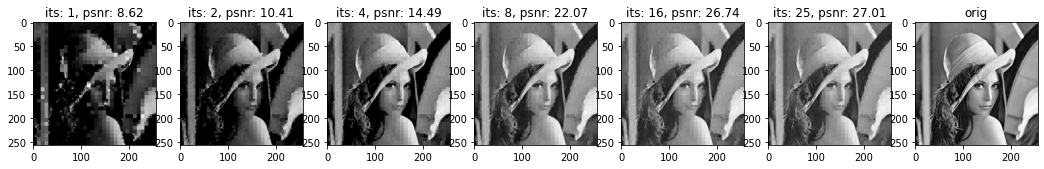

In [22]:
def show_decompress(orig, result, n_iterations=(1, 2, 4, 8, 16, 25)):
    images = []
    for n in tqdm(n_iterations):
        images.append(comp.decompress(result, n))

    _, axs = plt.subplots(ncols=len(images) + 1)
    for index in range(len(images)):
        axs[index].imshow(images[index], cmap='gray')
        axs[index].set_title(f'its: {n_iterations[index]}, psnr: {round(psnr(images[index], orig), 2)}')

    axs[-1].imshow(orig, cmap='gray')
    axs[-1].set_title('orig')

    plt.show()

show_decompress(lenna_gray_256x256, result_gray)

## Разберемся с `YUV`

Вот так выглядят компоненты YUV изображения.

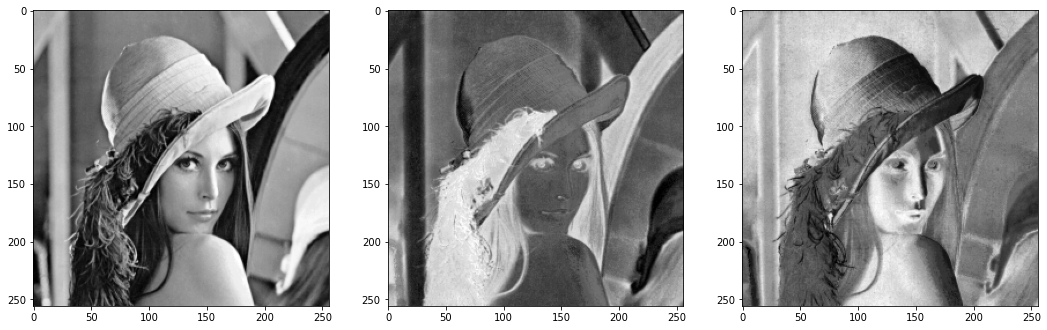

In [23]:
def plot_yuv(image):
    components = np.split(rgb2yuv(image), [1, 2], axis=2)

    _, axs = plt.subplots(ncols=len(components))

    for idx, component in enumerate(components):
        axs[idx].imshow(component, cmap='gray')

    plt.show()

plot_yuv(lenna_rgb_256x256)

#### Какие преобразования использует функция rgb2yuv?

Функция rgb2yuv принимает на вход rgb изображение, где каждый пиксель представлен тремя числами из диапазона `[0, 1]`.

Преобразуем три базисных вектора и на основе полученных данных составим матрицу преобразований.

In [24]:
def find_yuv_transform():
    i = [[[1.0, 0.0, 0.0]]]
    y = rgb2yuv(i)[0][0]

    j = [[[0.0, 1.0, 0.0]]]
    u = rgb2yuv(j)[0][0]

    k = [[[0.0, 0.0, 1.0]]]
    v = rgb2yuv(k)[0][0]

    return np.vstack((y, u, v)).T

find_yuv_transform()

array([[ 0.299     ,  0.587     ,  0.114     ],
       [-0.14714119, -0.28886916,  0.43601035],
       [ 0.61497538, -0.51496512, -0.10001026]])

#### Какие максимум и минимум достижимы для каждого канала?

Подбираем векторы так, чтобы получить максимальные и минимальные значения.

In [25]:
def find_yuv_minmax():
    z = [[[0.0, 0.0, 0.0]]]
    y_min = rgb2yuv(z)[0][0][0]
    o = [[[1.0, 1.0, 1.0]]]
    y_max = rgb2yuv(o)[0][0][0]

    z = [[[1.0, 1.0, 0.0]]]
    u_min = rgb2yuv(z)[0][0][1]
    z = [[[0.0, 0.0, 1.0]]]
    u_max = rgb2yuv(z)[0][0][1]

    z = [[[0.0, 1.0, 1.0]]]
    v_min = rgb2yuv(z)[0][0][2]
    z = [[[1.0, 0.0, 0.0]]]
    v_max = rgb2yuv(z)[0][0][2]

    df = pd.DataFrame(data={
        'components': ['Y', 'U', 'V'],
        'min': [y_min, u_min, v_min],
        'max': [y_max, u_max, v_max]
    })

    return df

find_yuv_minmax()

,components,min,max
0,Y,0.000000,1.000000
1,U,-0.436010,0.436010
2,V,-0.614975,0.614975


#### Изобретая свой ~~велосипед~~ `rgb2ycbcr`

Будет здорово сжимать изображение `[0, 255]`. Не буду использовать YCbCr так, как он уменьшает диапазон по Y. Изобретем свое преобразование на основе `rgb2yuv`, так чтобы результат был представим в типе `uint8`.

Минимум и максимум в rgb изображении: 0.013519764031939482 0.9524251129883163
На некоторых изображениях получаем выходящие за пределы яркости. Лучше всего их обрезать.
PSNR: 58.37739590009431


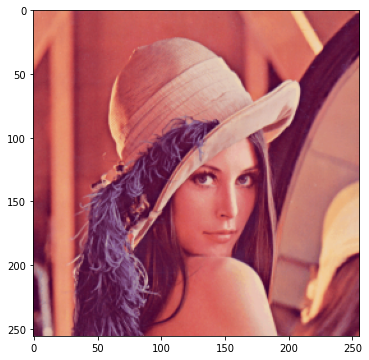

In [26]:
def my_rgb2yuv(image):
    y, u, v = np.split(rgb2yuv(image), [1,2], axis=2)

    y8 = (y + 0.000) * 255
    u8 = (u + 0.436) * 292
    v8 = (v + 0.615) * 207

    # Compress, decompress
    y8 = np.rint(y8).astype(np.uint8)
    u8 = np.rint(u8).astype(np.uint8)
    v8 = np.rint(v8).astype(np.uint8)

    y = y8 / 255 - 0.000
    u = u8 / 292 - 0.436
    v = v8 / 207 - 0.615

    rgb = yuv2rgb(np.dstack((y, u, v)))

    print('Минимум и максимум в rgb изображении:', rgb.min(), rgb.max())
    print('На некоторых изображениях получаем выходящие за пределы яркости. Лучше всего их обрезать.')
    rgb[rgb < 0] = 0
    rgb[rgb > 1] = 1
    rgb = np.rint(rgb * 255).astype(np.uint8)
    plt.imshow(rgb)

    print('PSNR:', weighted_psnr(rgb, lenna_rgb_256x256))

my_rgb2yuv(lenna_rgb_256x256)

In [27]:
from skimage.color import rgb2ycbcr, ycbcr2rgb
print(weighted_psnr(np.rint(ycbcr2rgb(np.rint(rgb2ycbcr(lenna_rgb_256x256))) * 255).astype(np.uint8), lenna_rgb_256x256))

57.37236644208493


Свой велосипед немного лучше библиотечного решения, так как хранит данные в полном диапазоне.

#### Эксперимент1. Каналы похожи друг на друга. Что если получать U или V из Y?

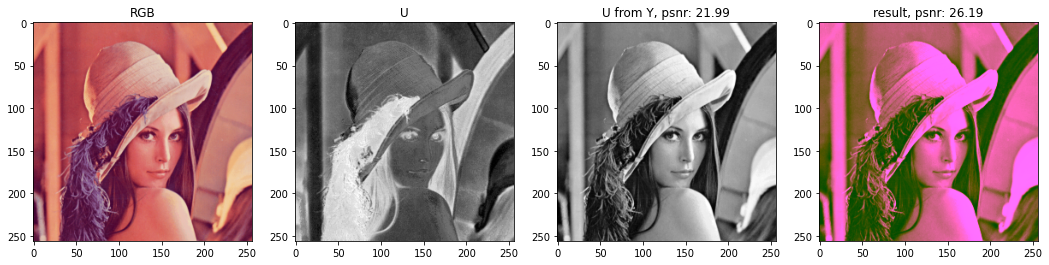

In [29]:
def only_y_transform(image):
    _, axs = plt.subplots(ncols=4)

    y, u, v = np.split(rgb2yuv(image), [1,2], axis=2)

    axs[0].imshow(image)
    axs[0].set_title('RGB')
    axs[1].imshow(u, cmap='gray')
    axs[1].set_title('U')

    y8 = (y + 0.000) * 255
    u8 = (u + 0.436) * 292
    v8 = (v + 0.615) * 207

    tr = find_block_transform(u8, y8, 0, 0, y8.shape[0], 1)
    intensity_offset_u8 = tr.intensity_offset

    tr = find_block_transform(v8, y8, 0, 0, y8.shape[0], 1)
    intensity_offset_v8 = tr.intensity_offset

    u8_from_y8 = 0.75 * y8 + intensity_offset_u8
    v8_from_y8 = 0.75 * y8 + intensity_offset_v8

    # Compress, decompress

    y = y8 / 255 - 0.000
    u_from_y = u8_from_y8 / 292 - 0.436
    v_from_y = v8_from_y8 / 207 - 0.615

    axs[2].imshow(u_from_y, cmap='gray')
    axs[2].set_title(f'U from Y, psnr: {round(psnr(u, u_from_y), 2)}')

    rgb = yuv2rgb(np.dstack((y, u_from_y, v_from_y)))
    rgb[rgb < 0] = 0
    rgb[rgb > 1] = 1

    axs[3].imshow(rgb, cmap='gray')
    axs[3].set_title(f'result, psnr: {round(weighted_psnr(rgb, image), 2)}')

    plt.show()

only_y_transform(lenna_rgb_256x256)

U восстановленный из Y совершенно непохож на оригинал.

На общем изображении видно сильное искажение цветов.

#### Эксперимент 2. Что если хранить меньше информации о цвете?

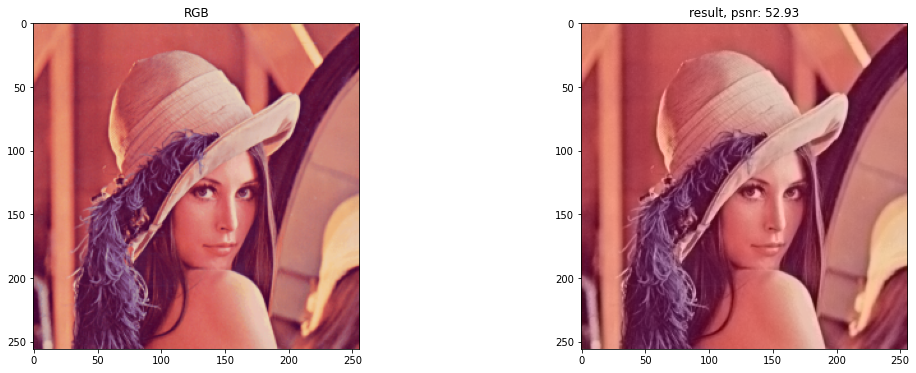

In [30]:

def resize_uv_transform(image, mn=8):
    _, axs = plt.subplots(ncols=2)

    y, u, v = np.split(rgb2yuv(image), [1,2], axis=2)

    axs[0].imshow(image)
    axs[0].set_title('RGB')

    u = resize(u, (u.shape[0] // mn, u.shape[1] // mn))
    v = resize(v, (v.shape[0] // mn, v.shape[1] // mn))

    y8 = (y + 0.000) * 255
    u8 = (u + 0.436) * 292
    v8 = (v + 0.615) * 207

    # Compress, decompress

    y = y8 / 255 - 0.000
    u = u8 / 292 - 0.436
    v = v8 / 207 - 0.615

    u = resize(u, (u.shape[0] * mn, u.shape[1] * mn))
    v = resize(v, (v.shape[0] * mn, v.shape[1] * mn))

    rgb = yuv2rgb(np.dstack((y, u, v)))
    rgb[rgb < 0] = 0
    rgb[rgb > 1] = 1

    axs[1].imshow(rgb)
    axs[1].set_title(f'result, psnr: {round(weighted_psnr(rgb, image), 2)}')

    plt.show()

resize_uv_transform(lenna_rgb_256x256)

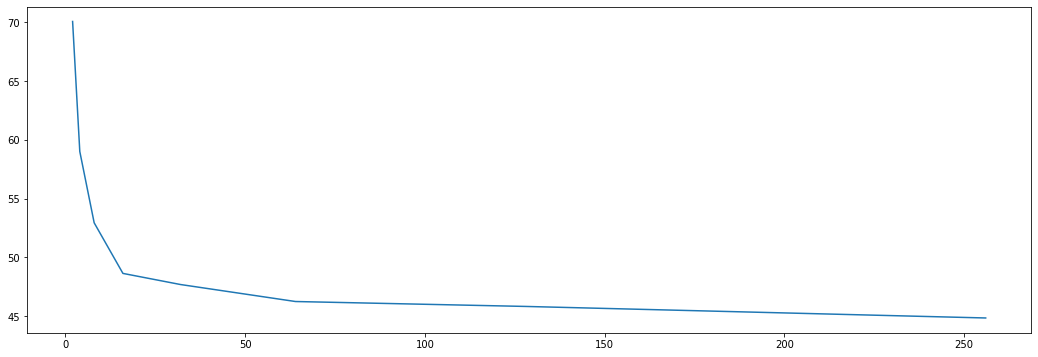

In [31]:
def optimal_mn(image, mns = (2, 4, 8, 16, 32, 64, 128, 256)):
    psnrs = []

    for mn in mns:
        y, u, v = np.split(rgb2yuv(image), [1,2], axis=2)
        u = resize(u, (u.shape[0] // mn, u.shape[1] // mn))
        v = resize(v, (v.shape[0] // mn, v.shape[1] // mn))

        y8 = (y + 0.000) * 255
        u8 = (u + 0.436) * 292
        v8 = (v + 0.615) * 207

        # Compress, decompress

        y = y8 / 255 - 0.000
        u = u8 / 292 - 0.436
        v = v8 / 207 - 0.615

        u = resize(u, (u.shape[0] * mn, u.shape[1] * mn))
        v = resize(v, (v.shape[0] * mn, v.shape[1] * mn))

        rgb = yuv2rgb(np.dstack((y, u, v)))
        rgb[rgb < 0] = 0
        rgb[rgb > 1] = 1

        psnrs.append(weighted_psnr(rgb, image))

    plt.plot(mns, psnrs)

optimal_mn(lenna_rgb_256x256)

Уменьшение размера U и V оказывает минимальное влияние.

## Цветное изображение

In [32]:
result_rgb = comp.compress2(lenna_rgb_256x256, quality=60)

100%|██████████| 256/256 [00:00<00:00, 4232.60it/s]


In [33]:
len(result_rgb)

7474

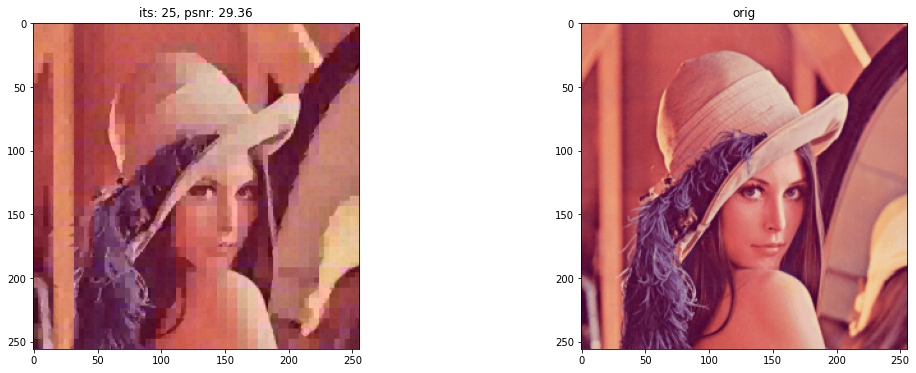

In [34]:
def show_colored_decompress(orig, result):
    img = comp.decompress(result, 25)
    _, axs = plt.subplots(ncols=2)
    axs[0].imshow(img)
    axs[0].set_title(f'its: 25, psnr: {round(weighted_psnr(orig, img), 2)}')
    axs[1].imshow(orig, cmap='gray')
    axs[1].set_title('orig')

    plt.show()

show_colored_decompress(lenna_rgb_256x256, result_rgb)

## Подбор параметра `loss_limit`

Параметр влияет на количество просматриваемых блоков. Его увеличение приводит к значительному ускорению программы за счет качества найденных блоков.

100%|██████████| 256/256 [00:00<00:00, 3896.35it/s]


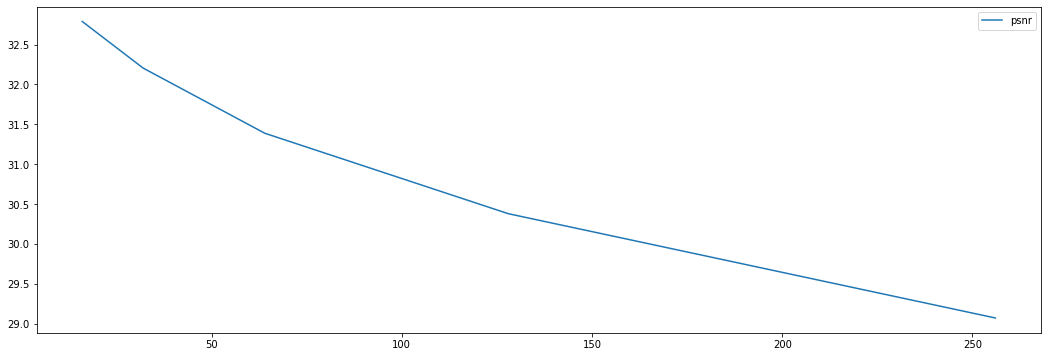

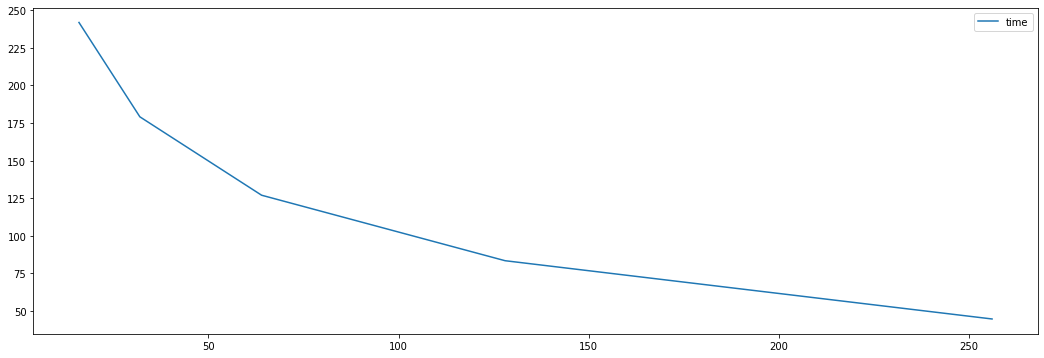

In [36]:
def find_loss_limit(image, loss_limits=(16, 32, 64, 128, 256)):
    data = {
        'loss_limit': [],
        'psnr': [],
        'time': []
    }

    for loss_limit in loss_limits:
        start = time.time()
        result = comp.compress(image, block_size=8, stride=4, block_size_limit=4, uv_block_size=16, loss_limit=loss_limit)
        result = comp.decompress(result, 25)
        duration = time.time() - start

        data['loss_limit'].append(loss_limit)
        data['psnr'].append(weighted_psnr(result, image))
        data['time'].append(duration)

    df = pd.DataFrame(data={
        'loss_limit': data['loss_limit'],
        'psnr': data['psnr'],
        'time': data['time']
    })

    plt.plot(df['loss_limit'], df['psnr'], label='psnr')
    plt.legend()
    plt.show()

    plt.plot(df['loss_limit'], df['time'], label='time')
    plt.legend()
    plt.show()

find_loss_limit(lenna_rgb_256x256)

Небольшие значения `loss_limit` приводят к слишком долгим поискам блоков. Выберем большое значение для ускорения.

## Построим график качества
Качество в данном случае будет измеряться по PSNR (а значит в децибелах).

Это базовый график для понимания соотношения между коэффициентом сжатия и качеством, получаемым на выходе. Можно посмотреть, как он будет меняться в зависимости от количества итераций при декомпрессии, например.

In [37]:
def test_image(img, quality=(0, 20, 40, 60, 80, 100)):
    compressed_images = [comp.compress2(img, quality=q) for q in quality]
    decompressed_images = [comp.decompress(compressed) for compressed in compressed_images]
    compression_rates = np.array([len(compressed) for compressed in compressed_images]) / img.size
    psnrs = [weighted_psnr(img, decompressed) for decompressed in decompressed_images]
    return compression_rates, psnrs, decompressed_images

In [42]:
def plot_results(results):
    _, ax = plt.subplots()

    compression_rates, psnrs, _ = results
    ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')

    ax.set_xlabel('Compression Rate', fontsize=16)
    ax.set_ylabel('PSNR, dB', fontsize=16)

    plt.show()

In [45]:
def plot_images(results, quality=(0, 20, 40, 60, 80, 100)):
    _, axs = plt.subplots(ncols=len(quality))

    compression_rates, psnrs, decompressed_images = results
    for i, image in enumerate(decompressed_images):
        axs[i].imshow(image)
        orig_size = 256 * 256 * 3
        axs[i].set_title(f'psnr: {round(psnrs[i], 2)}, size: {compression_rates[i] * orig_size}')

    plt.show()

In [40]:
lenna_results = test_image(lenna_rgb_256x256)

100%|██████████| 256/256 [00:00<00:00, 2970.69it/s]


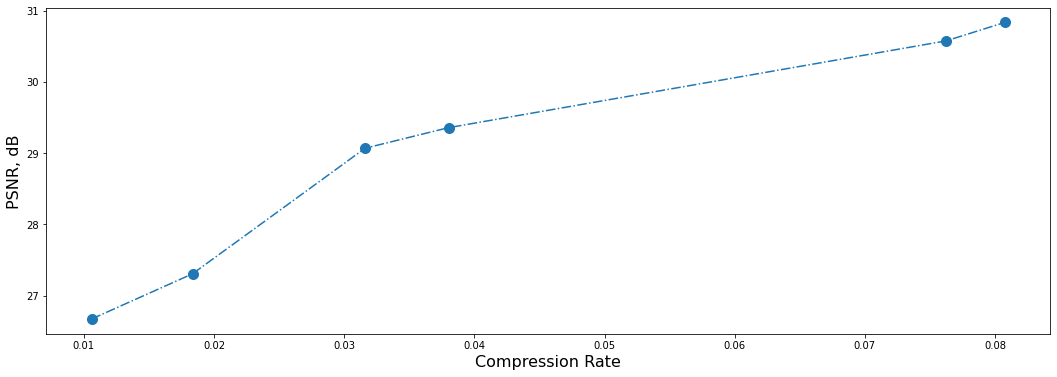

In [43]:
plot_results(lenna_results)

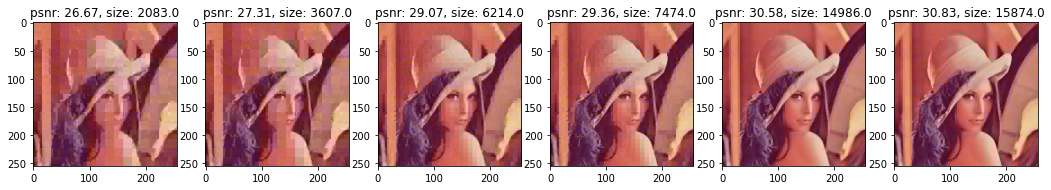

In [46]:
plot_images(lenna_results)

## Улучшим алгоритм
Одним из основных способов улучшения сжатия изображений является разбиение картинки не на равные блоки, а на блоки разных размеров. Как дополнительную часть задания, мы предлагаем реализовать разбиение квадродеревом, это позволит более гибко настраивать параметры сжатия и получить лучшие результаты.

<center>Пример разбиения изображения на блоки с использованием квадродерева</center>

Исходное изображение | Разбиение квадродеревом
- | -
![Source image](images/house.jpg) | ![Segmentation](images/quadtree.jpg)

## Changelog

1. Наивная реализация
1. Оптимизирован поиск `intensity offset`
1. Добавлена функция поиска поворотов и отражений на основе полного перебора
1. Вместо изменения размера каждого блока, изменяется размер всего изображения
1. Реализовано вычисление `intensity scale` для каждого блока
1. Добавлена поддержка сжатия цветных изображений на основе конвертации в `YUV`
1. Реализовано квадродерево
1. Ограничения на возможные значения параметра `intensity scale`
1. Быстрое сравнение рангового и доменных блоков на пригодность
1. Обновление битового массива для повышения эффективности сжатия при использовании квадродерева
1. Добавлены настройки квадродерева
1. Умный алгоритм поиска поворотов и отражений
1. Прореживание неважных компонент цветного изображения
1. Добавлена коррекция разжатого `RGB` изображения
1. Поиск блока останавливается при достижении приемлемого качества
1. Добавлены пояснения и визуализация